In [72]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.planar_fixed_structure.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *

import meshcat
import meshcat.geometry as meshcat_geom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)

def make_orthographic(xmin,  xmax, ymin, ymax, camera_position):
    # Taken from https://github.com/RobotLocomotion/drake/blob/master/bindings/pydrake/systems/meshcat_visualizer.py
    camera = meshcat_geom.OrthographicCamera(
        left=xmin, right=xmax, top=ymax, bottom=ymin, near=-1000, far=1000)
    vis['/Cameras/default/rotated'].set_object(camera)
    vis['/Cameras/default'].set_transform(
        RigidTransform(camera_position).GetAsMatrix4())

    # Lock the orbit controls.
    vis['/Cameras/default/rotated/<object>'].set_property(
        "position", [0, 0, 0])
    vis['/Background'].set_property("visible", False)
    vis['/Grid'].set_property("visible", False)
    vis['/Axes'].set_property("visible", False)
        
make_orthographic(-2, 2, -2, 2, np.array([0., 0., 1.]))

from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))


Meshcat url:  http://127.0.0.1:7014/static/


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...
Loading...
Loaded 100 scenes.


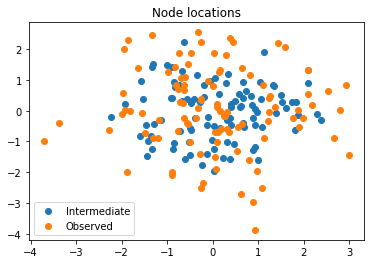

In [66]:
# Sample a dataset of scenes from the default grammar params.
# Draw a random sample from the grammar and visualize it.
# (Cache output.)
torch.random.manual_seed(2)
N_samples = 100
RESAMPLE = True
scenes_file = "sampled_scenes_%d.dat" % N_samples

ground_truth_grammar = SpatialSceneGrammar(
    root_node_type = RootNode,
    root_node_tf = torch.eye(4)
)

if not os.path.exists(scenes_file) or RESAMPLE:
    samples = []
    for k in tqdm(range(N_samples)):
        tree = ground_truth_grammar.sample_tree(detach=True)
        observed_nodes = tree.get_observed_nodes()
        samples.append((tree, observed_nodes))

    print("Saving...")
    with open(scenes_file, "wb") as f:
        pickle.dump(samples, f)

print("Loading...")
with open(scenes_file, "rb") as f:
    samples = pickle.load(f)
print("Loaded %d scenes." % len(samples))
observed_node_sets = [x[1] for x in samples]

def get_all_node_xys(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation[:2].detach().cpu().numpy())
    return np.stack(l)

plt.figure()
plt.title("Node locations")
l = get_all_node_xys([sample[0] for sample in samples], HiddenNode)
plt.scatter(l[:, 0], l[:, 1], label="Intermediate")
l = get_all_node_xys([sample[0] for sample in samples], VisibleNode)
plt.scatter(l[:, 0], l[:, 1], label="Observed")
plt.legend()

# And draw some of the trees in visualizer; not too many, it makes it slow.
for k in range(10):
    draw_scene_tree_contents_meshcat(samples[k][0], zmq_url=vis.window.zmq_url, prefix="dataset/contents/sample_%d" % k)
    draw_scene_tree_structure_meshcat(samples[k][0], zmq_url=vis.window.zmq_url, prefix="dataset/structures/sample_%d" % k)

# Posterior sample diversity
One thing I want to check out: when I ask my sampling procedure to produce samples from the posterior for a given scene, how diverse are those samples?

In [67]:
sample_observed = samples[k][1]
xy = sample_observed[1].translation.detach().numpy()[:2]
print("Point xy: ", xy)

# Compute the true posterior in close form. p(latent mu | observed x)
# is product of prior (mu ~ N[0, 1]) and likelihood (x ~ N[mu, 1],
# or by symmetry mu ~ N[x, 1]).
# Ref https://math.stackexchange.com/questions/157172/product-of-two-multivariate-gaussians-distributions,
# but it simplifies since all covariances are identity.
posterior_mu = xy / 2.
posterior_sigma = np.eye(2)/2.

Point xy:  [ 2.66797899 -0.89801764]


In [116]:
sample_observed = samples[k][1]
posterior_samples = collect_posterior_sample_sets(
    ground_truth_grammar, [sample_observed], tqdm=tqdm,
    hmc_strategy="NUTS", num_samples=1000, subsample_step=1
)

Sample: 100%|██████████| 1050/1050 [01:48,  9.69it/s, step size=2.53e-02, acc. prob=0.913]


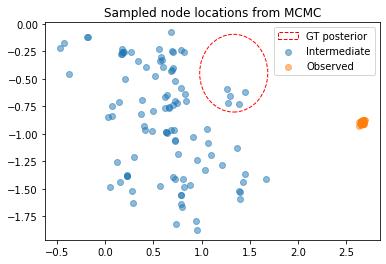

In [115]:
plt.figure()
plt.title("Sampled node locations from MCMC")
l = get_all_node_xys(posterior_samples[0], HiddenNode)
plt.scatter(l[:, 0], l[:, 1], label="Intermediate", alpha=0.5)
l = get_all_node_xys(posterior_samples[0], VisibleNode)
plt.scatter(l[:, 0], l[:, 1], label="Observed", alpha=0.5)

# Really taking advantage of simple form of posterior here.
from matplotlib.patches import Ellipse
ellipse = Ellipse(
    posterior_mu, width=np.sqrt(posterior_sigma[0, 0]), height=np.sqrt(posterior_sigma[1, 1]),
    facecolor='none', edgecolor='red', label="GT posterior", linestyle="--"
)
plt.gca().add_patch(ellipse)
plt.legend()

In [63]:
# Instead rejection-sample to get a posterior.
N_rejection_samples = 100000
rejection_samples = []
t = tqdm(range(N_rejection_samples))
for k in t:
    tree = ground_truth_grammar.sample_tree(detach=True)
    observed_nodes = tree.get_observed_nodes()
    sampled_xy = observed_nodes[1].translation.detach().numpy()[:2]
    if np.linalg.norm(sampled_xy - xy) < 0.2:
        rejection_samples.append(tree)
    t.set_description("%d positive samples" % len(rejection_samples))

  0%|          | 0/100000 [00:00<?, ?it/s]

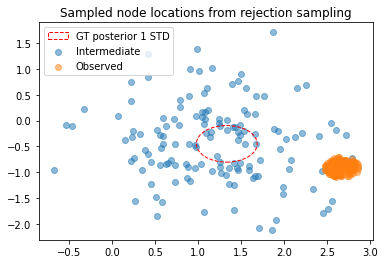

In [64]:
plt.figure()
plt.title("Sampled node locations from rejection sampling")
l = get_all_node_xys(rejection_samples, HiddenNode)
plt.scatter(l[:, 0], l[:, 1], label="Intermediate", alpha=0.5)
l = get_all_node_xys(rejection_samples, VisibleNode)
plt.scatter(l[:, 0], l[:, 1], label="Observed", alpha=0.5)

# Really taking advantage of simple form of posterior here.
from matplotlib.patches import Ellipse
ellipse = Ellipse(
    posterior_mu, width=np.sqrt(posterior_sigma[0, 0]), height=np.sqrt(posterior_sigma[1, 1]),
    facecolor='none', edgecolor='red', label="GT posterior 1 STD", linestyle="--"
)
plt.gca().add_patch(ellipse)
plt.legend()